In [1]:
from lorenzetti_utils.read_events import *
from Gaugi import load
from Gaugi.monet.utils import getColor,getColors
from Gaugi.monet.PlotFunctions import *
from Gaugi.monet.TAxisFunctions import *
from Gaugi.monet.AtlasStyle import *
from Gaugi import stdvector_to_list, progressbar
from ROOT import TCanvas, TH1F, TH1I, TFile
from ROOT import TLatex, gPad
from ROOT import kRed, kBlue, kBlack,TLine,kBird, kOrange,kGray, kYellow, kViolet, kGreen, kAzure
from pprint import pprint
from pandas import DataFrame


import array
import numpy as np
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
SetAtlasStyle()
GeV=1000.

Welcome to JupyROOT 6.22/00
Using all sub packages with ROOT dependence

Applying ATLAS style settings...


In [2]:
def read_events( path , nov=-1):
    
    event = EventStore(path, "physics")
    vars = ['et','eta','phi','reta','rphi','rhad','eratio','weta2','f1','f3']
    d = { key:[] for key in vars }
    d['rings'] = []
    d['rp_values']=[]
    d['rp_rings']=[]
    
    if nov < 0 or nov > event.GetEntries():
        nov = event.GetEntries()
    
    for entry in progressbar( range(nov) , event.GetEntries() , prefix='Reading...') : 
        event.GetEntry(entry) 
        
        cluster_cont = event.retrieve("CaloClusterContainer_Clusters")
        
        for caloRings in event.retrieve("CaloRingsContainer_Rings"):
            
            emClus = cluster_cont.at(caloRings.cluster_link)
            for key in vars:
                d[key].append( getattr(emClus,key) ) 
            d['rp_values'].append(stdvector_to_list(emClus.rp_values))
            d['rings'].append(stdvector_to_list(caloRings.rings))
        for caloRings in event.retrieve("CaloRingsContainer_RpRings"):
            emClus = cluster_cont.at(caloRings.cluster_link)
            d['rp_rings'].append(stdvector_to_list(caloRings.rings))
    
    return DataFrame(d)

In [3]:
path = '/home/juan/lorenzetti/files/rp/Zee/AOD/Zee.AOD.root'
zee_mb = read_events(path)
path = '/home/juan/lorenzetti/files/rp/JF17/AOD/JF17.AOD.root'
jet_mb = read_events(path)

Reading...|############################################################| 5/5
Reading...... finished task in 0.128197s.
Reading...|############################################################| 5/5
Reading...... finished task in 0.188983s.


In [4]:
def AddLegend(canvas, x, y, legends, option='f'):
    MakeLegend( canvas,x,y,x+0.98,y+0.20,textsize=16, names=legends, option = option )
    
def CreateHist(values, name, bins, xmin, xmax):
    h = TH1F(name, "", bins, xmin, xmax)
    w = array.array( 'd', np.ones_like(values) )
    if isinstance(values, list):
        h.FillN( len(values), array.array('d',  values),  w)
    else:
        h.FillN( len(values), array.array('d',  values.tolist()),  w)
    return h

def LZTLabel(canvas, x,y,text,color=1):
    l = TLatex()
    l.SetNDC()
    l.SetTextFont(72)
    l.SetTextColor(color)
    delx = 0.17*696*gPad.GetWh()/(472*gPad.GetWw())
    l.DrawLatex(x,y,"Lorenzetti")
    p = TLatex()
    p.SetNDC()
    p.SetTextFont(42)
    p.SetTextColor(color)
    p.DrawLatex(x+delx,y,text)
    canvas.Update()
    
def PlotHist( values_sgn, values_bkg , xlabel, bins, xmin, xmax , y_axis_maximum=None):
    from Gaugi.monet.utils import NormHist
    h_sgn = CreateHist(values_sgn, 'sgn', bins, xmin, xmax)
    h_bkg = CreateHist(values_bkg, 'bkg', bins, xmin, xmax)
    # Create canvas
    canvas = TCanvas('canvas','canvas',700, 500)
    h_sgn = NormHist(h_sgn)
    h_bkg = NormHist(h_bkg)
    h_sgn.SetLineColor(kAzure)
    h_sgn.SetFillColor(kAzure-4)
    h_bkg.SetLineColor(kRed)
    h_bkg.SetFillColor(getColor(kRed, 0.5))
    if y_axis_maximum:
        h_sgn.SetMaximum(y_axis_maximum)
        h_bkg.SetMaximum(y_axis_maximum)
    AddHistogram(canvas,h_sgn, 'same')
    AddHistogram(canvas,h_bkg, 'same')
    FormatCanvasAxes(canvas, XLabelSize=16, YLabelSize=16, XTitleOffset=0.87, ZLabelSize=16,
                             ZTitleSize=16, YTitleOffset=1.10, ZTitleOffset=1.1)
    SetAxisLabels(canvas,xlabel, 'counts/bin (norm by counts)')
    return canvas

def createRingProfile(rings, norm=False):
    from ROOT import TGraph
    import numpy as np
    if norm: 
        graph = TGraph(len(rings),np.array(range(0,len(rings)),dtype='double'), np.array(rings, dtype='double')/max(rings))
        return graph
    else: 
        graph = TGraph(len(rings),np.array(range(0,len(rings)),dtype='double'), np.array(rings, dtype='double'))
        return graph

In [5]:
event = 3
zee_rings = zee_mb['rings'].values[event]
jet_rings = jet_mb['rings'].values[event]
zee_rp_rings = zee_mb['rp_rings'].values[event]
jet_rp_rings = jet_mb['rp_rings'].values[event]

ZeeRings   = createRingProfile(zee_rings, norm=True)
ZeeRpRings = createRingProfile(zee_rp_rings, norm=True)
JetRings   = createRingProfile(jet_rings, norm=True)
JetRpRings = createRingProfile(jet_rp_rings, norm=True)

## Zee Ringer Profile Plots:

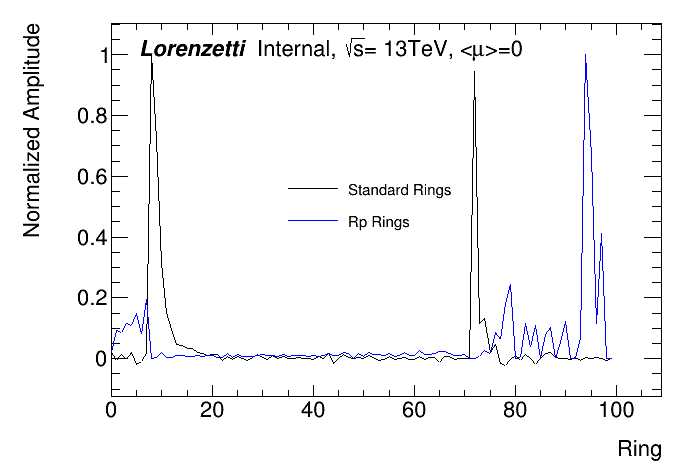

In [6]:
ZeeCanvas = TCanvas('zeecanvas','zeecanvas',700, 500)
ZeeRings.Draw('AL')
ZeeRpRings.SetLineColor(kBlue)
ZeeRpRings.Draw('L')
AddLegend( ZeeCanvas,0.4,0.5, ['Standard Rings', 'Rp Rings'], option='l')
LZTLabel(ZeeCanvas, 0.2, 0.88, 'Internal, #sqrt{s}= 13TeV, <#mu>=0')
ZeeRings.GetYaxis().SetTitle('Normalized Amplitude')
ZeeRings.GetXaxis().SetTitle('Ring')
ZeeCanvas.Draw()

## Jet Ringer Profile Plots:

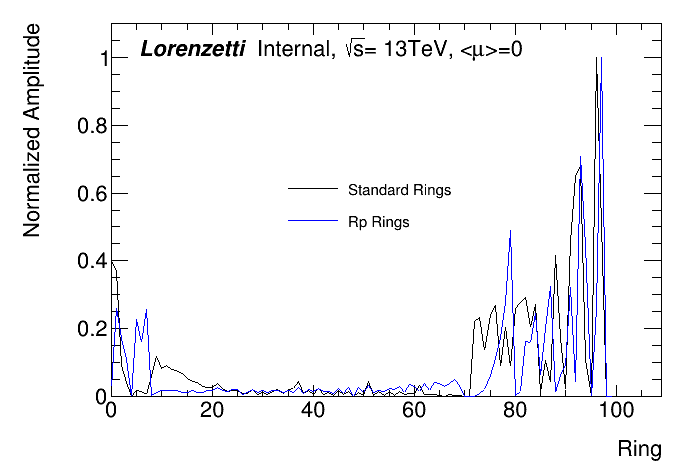

In [7]:
JetCanvas = TCanvas('Jetcanvas','Jetcanvas',700, 500)
JetRings.Draw('AL')
JetRpRings.SetLineColor(kBlue)
JetRpRings.Draw('L')
AddLegend( JetCanvas,0.4,0.5, ['Standard Rings', 'Rp Rings'], option='l')
LZTLabel(JetCanvas, 0.2, 0.88, 'Internal, #sqrt{s}= 13TeV, <#mu>=0')
JetRings.GetYaxis().SetTitle('Normalized Amplitude')
JetRings.GetXaxis().SetTitle('Ring')
JetCanvas.Draw()